
#  Modeling : Ensemble Climate Projections

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

This file constructs ML classifiers for the desert night lizard's distribution. The classes are binary indicating a presence/background, the latter of which was a randomly drawn as a "pseudo absence" set. Train and test (80/20) sets were split in RStudio, where ten decorrelated BioClim features (1970-2000) were extracted per presence/absence location. 

### Comparing ML Classifiers with PyCaret and Scikit-learn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)|
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | C*100
|BioClim6| Min Temp Coldest Month| C
|BioClim7| Temp Annual Range| C
|BioClim8| Mean Temp Wettest Quareter | C
|BioClim9| Mean Temp Driest Quareter | C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

In [33]:
exec(open('/Users/danielfurman/Data_science_code/ML_sdms_train.py').read())

# Binary classification with ten BioClim features. Five are a function of precipitation and five of temperature, all
# decorrelated below a 0.5 correlation threshold. We use PyCaret to train and tune (10-fold cv) our models from a 
# train set that contains 80%  of the total data. We find that random forest, xgboost, lgbm, catboost, and
# extra trees algorithms perform best. The last step was to create blended model from these five.

Transformation Pipeline and Model Succesfully Saved
PyCaret training ended 






Fraction correct validation Random Forest : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.9436201780415431


Fraction correct validation XGBoost : 0.9691032403918614
[[970  25]
 [ 16 316]]
The F1 validation score is :  0.9390787518573551


Fraction correct validation Extra Trees : 0.9713639788997739
[[972  23]
 [ 15 317]]
The F1 validation score is :  0.9434523809523809


Fraction correct validation LGBoost Machine : 0.9713639788997739
[[971  24]
 [ 14 318]]
The F1 validation score is :  0.9436201780415431


Fraction correct validation MLP neural-net : 0.9382064807837227
[[944  51]
 [ 31 301]]
The F1 validation score is :  0.8801169590643274


Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Blended model : 0.9713639788997739
[[972  23]
 [ 15 317]]
The F1 validation score is :  0.9434523809523809


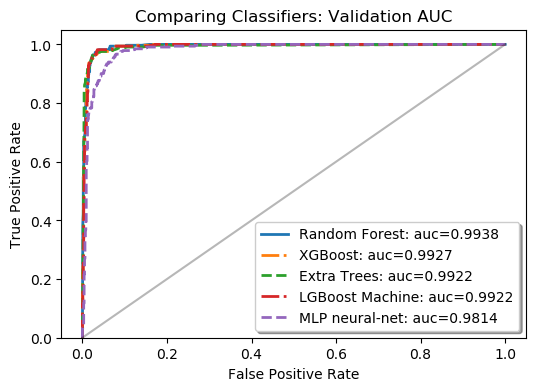

In [41]:
exec(open('/Users/danielfurman/Data_science_code/ML_sdms_predict.py').read())

# Now that we have trained and tuned our ML models, we are ready to predict the validation set and examine the models'
# performance. We first print the validation set accuracy, as well as the F statistic and the 2x2 confusion matrix.
# Finally, we visualize the AUC statistic with a ROC curve for each model. We also examine the results of a blended
# model constructed from the afformentioned five most predictive learners. 

In [42]:
f_score # F-statistic for the five models above, as well as a blended model
# We find Random Forest as the winner in terms of validation AUC and F-stat

,RForest,LGBM,Extra Trees,Blended,XGBoost,MLP-net
F-statistic :,0.94362,0.94362,0.943452,0.943452,0.939079,0.880117
